# Haar Compression Activity
stough 202-

DIP 6, 8.9

In this activity you're going to use the Haar wavelet block transform and lossy compression in two different contexts

- A single $4x4$ single-channel "image" block with fairly high contrast.
- A larger color image with $8x8$ blocks.

In each case we're going to 

- Transform: Turn a block of image pixels into a block of Haar wavelet coefficients. 
- Compress: We're going to effectively compress by zeroing out insigficant/small coefficients.
- Reconstruct: Take the "compressed" coefficent block and reconstruct the block of image pixels, with some loss.

Recall from [`view_basis_blocks`](./view_basis_blocks.ipynb) that the Haar $4x4$ transform matrix is like so:

\begin{equation*}
\mathbf{H_{Haar}} =  \frac{1}{2}\begin{vmatrix}
1 & 1 & 1 & 1\\
1 & 1 & -1 & -1 \\
{\sqrt 2} & -{\sqrt 2} & 0 & 0 \\
0 & 0 & {\sqrt 2} & -{\sqrt 2}
\end{vmatrix}
\end{equation*}

To transform a block of pixels $\mathbf{B}$ into a block of coefficients:

\begin{equation*}
\mathbf{T} = \mathbf{H}\times\mathbf{B}\times\mathbf{H}^T
\end{equation*}

where $\mathbf{H}^T$ is the transpose. Through the above we basically replace the set of independent pixels with the set of coefficients with respect to the Haar basis patterns, as we'll see with `vis_blocks`. Once we have $\mathbf{T}$, we can quantize it to the degree that we wish, zeroing out small coefficients, potentially replacing large coefficients with nearby approximations on a standard grade (e.g. replace anything in $[236,276]$ with $256$). 

To reconstruct the original $\mathbf{B}$, we can simply

\begin{equation*}
\mathbf{B} = \mathbf{H}^T\times\mathbf{T}\times\mathbf{H}
\end{equation*}

## Imports
We're going to use [`wavelet_utils`](../dip_utils/wavelet_utils.py).

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# For importing from alternative directory sources
import sys  
sys.path.insert(0, '../dip_utils')

from matrix_utils import (arr_info,
                          make_linmap)
from vis_utils import (vis_rgb_cube,
                       vis_hists,
                       vis_pair,
                       vis_surface)

from wavelet_utils import (make_haar_matrix,
                           make_random_basis,
                           make_klt_basis,
                           make_dct_matrix,
                           make_standard_matrix,
                           vis_blocks)


from skimage.util import view_as_blocks
from skimage.util import montage
from skimage.transform import resize, rescale

## 1. $4\times4$ Haar Wavelet Compression
Use `make_haar_matrix` and `vis_blocks` to see the 16 Haar patterns for the $\mathbf{H_{Haar}}$ matrix

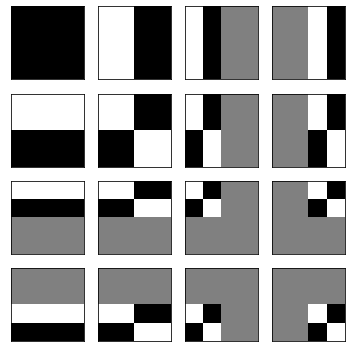

In [3]:
H = make_haar_matrix(4)
vis_blocks(H)

### Transform a $4\times4$ block of pixels.
We'll define the block of pixels in question. Then you transform it into the coefficient block $\mathbf{T}$. See [`np.matmul`](https://numpy.org/doc/stable/reference/generated/numpy.matmul.html) to compute $\mathbf{H}\times\mathbf{B}\times\mathbf{H}^T$.

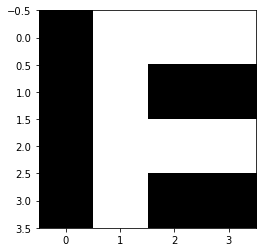

In [4]:
B = np.array([[0,1,1,1],
              [0,1,0,0],
              [0,1,1,1],
              [0,1,0,0]])

plt.figure(figsize=(4,4))
plt.imshow(B, cmap='gray')

In [5]:
HT = H.transpose()

In [6]:
# Haar basis for 2*2 {[1,1],[1,-1]}
# H B H^T = {[1,1],[1,-1]}*{[a,b],[c,d]}*{[1,1],[1,-1]}^T = {[a+b+c+d,a-b+c-d],[a+b-c-d, a-b-c+d]}

In [7]:
T = np.matmul(H,np.matmul(B,HT)) # 16 coefficient of energy required w.r.t the basis (don't call vis_blocks, which does outer product to it)

### A. Viewing the transform coefficients in the matrix $\mathbf{T}$, what are the row and column coords for the two largest coefficients (in absolute value)?

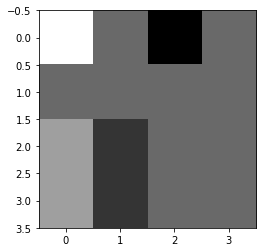

In [8]:
plt.figure()
plt.imshow(T, cmap='gray')

In [9]:
T

array([[ 2.00000000e+00,  0.00000000e+00, -1.41421356e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 7.07106781e-01, -7.07106781e-01, -4.26642159e-17,
         0.00000000e+00],
       [ 7.07106781e-01, -7.07106781e-01, -4.26642159e-17,
         0.00000000e+00]])

From the plot of the matrix T above we can tell the largest coefficients are 2 and -1.41 with coordinates (0,0) and (0,2) respectively.

### B. Show the two basis blocks corresponding to those two coefficients.

In [10]:
arr_info(H)

((4, 4), dtype('float64'), -0.7071067811865476, 0.7071067811865476)

In [11]:
Coef1 = np.outer(H[0],H[0])
Coef2 = np.outer(H[0],H[2])

Text(0.5, 1.0, 'Basis block of Coefficient -1.41')

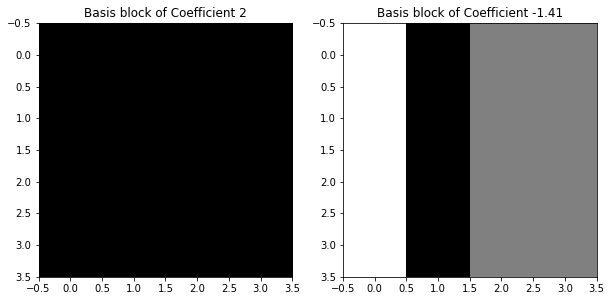

In [12]:
f, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(Coef1, cmap='gray', vmin=Coef1.min(), vmax=Coef1.max())
ax[0].set_title("Basis block of Coefficient 2")
ax[1].imshow(Coef2, cmap='gray', vmin=Coef2.min(), vmax=Coef2.max())
ax[1].set_title("Basis block of Coefficient -1.41")

### C. Show and explain as explicitly as you can how the two coefficients are what they are.

In the original image, we can see that column 0 and column 1 are all pure consistent color blocks, intuitively they are probably made up of very few blocks in the basis matrix. Then it is easy to find that the block at $[0,2]$ is the only one of this pattern, although of opposite color. Thus it could be negative coefficients. Then from the right half of the image we observe that there are two horizontal white stripes that could be probably made up of the block at $[0,2]$ and $[0,3]$. Then in order to make the most left column consistent the coefficient of the complete black block would possibly be large.

### D. Show the reconstruction of the image $\mathbf{B}$ using only those basis blocks/coefficients. 
Is this reconstruction trending in the right direction? Explain

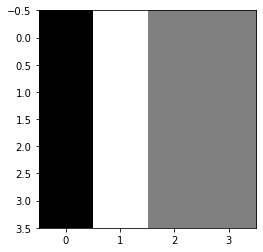

In [13]:
# B = 2*B0 + -1.41*B1 + ... coefficients are observed in T
plt.figure()
plt.imshow(2*Coef1 - 1.41421356*Coef2, cmap='gray', vmin=0, vmax=1)

Yes the pattern of the left half of the image has already match the original image. However since we are using only 2 coefficients while there are in total 16, the compression loss is huge and we can observe that the information on the right half of the original image is completely lost in this reconstruction.

## 2. Larger Image Block Transform and Reconstruction.
Use the code in [`block_viewing_demo`](./block_viewing_demo.ipynb) and [`basis_decomp_64pix.ipynb`](./basis_decomp_64pix.ipynb) to perform a similar transform/compress/reconstruct sequence on a larger image of your choice. 

- Use $8\times8$ blocks.
- Use [`resize`](https://scikit-image.org/docs/dev/api/skimage.transform.html?highlight=resize#skimage.transform.resize) on the image you choose to ensure that $8$ evenly divides it in height and width. This is for convenience: compression schemes have other mechanisms to deal with odd-shaped images, which we will ignore here.
- Perform reconstructions using the largest $[1,2,4,8,16]$ coefficients in absolute value per block. Note that keeping $16$ coefficients is equivalent to $\sim 3$x compression. 
- For at least the reconstructions using $[2,4]$, use `vis_pair` and zoom into an area to observe the effectiveness of the reconstruction on such limit basis (32x, 16x compression).  

You can **export this notebook** as a PDF to submit this work.

In [14]:
def Grid_fig(blocklist):
    block_view = np.reshape(blocklist, [blocklist.shape[0]*blocklist.shape[1]] + list((8,8,3)))
    I_block_grid = montage(block_view, grid_shape=blocklist.shape[:2], multichannel=True, padding_width=0, fill=[1,1,1])
    return I_block_grid

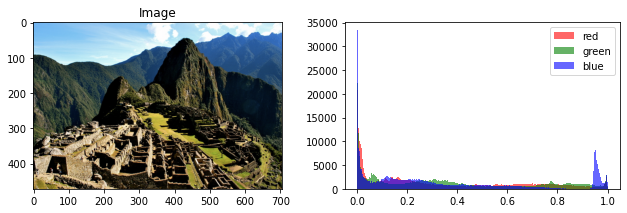

In [15]:
I = plt.imread('../dip_pics/machu.png')
I = I[...,:3]
vis_hists(I)

In [16]:
arr_info(I)

((472, 704, 3), dtype('float32'), 0.0, 1.0)

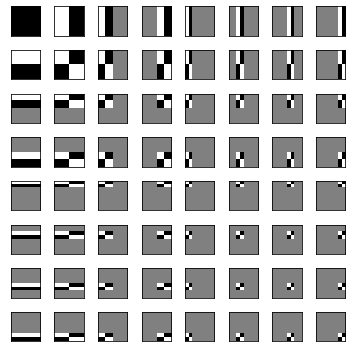

In [17]:
H2 = make_haar_matrix(8)
vis_blocks(H2)

In [18]:
block_shape = (8,8,3)
Blocks = view_as_blocks(I, block_shape) # list of original images
arr_info(Blocks)

((59, 88, 1, 8, 8, 3), dtype('float32'), 0.0, 1.0)

In [19]:
# Generate the list of Coefficeint Matrices named Transforms
Transforms = Blocks.copy()
for i in range(len(Blocks)):
    for chan in range(3):
        Transforms[i][...,chan] = np.matmul(H2, np.matmul(Blocks[i][...,chan].copy(), H2.transpose()))

In [20]:
# Reconstruction -- Do Nothing
Recons = Transforms.copy()
for i in range(len(Blocks)):
    for chan in range(3):
        Recons[i][...,chan] = np.matmul(H2.transpose(), np.matmul(Transforms[i][...,chan].copy(), H2))

Text(0.5, 1.0, 'Reconstructed Image - No loss')

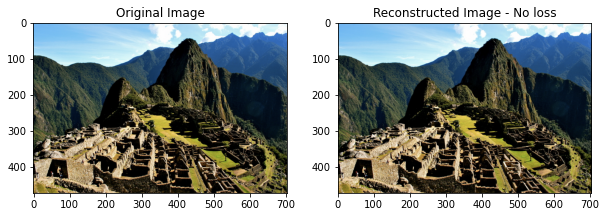

In [21]:
f, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(I)
ax[0].set_title("Original Image")
ax[1].imshow(np.clip(Grid_fig(Recons),0.0,1.0))
ax[1].set_title("Reconstructed Image - No loss")

## Lossy Compression -- Using largest $[1,2,4,8,16]$ coefficients

In [22]:
def n_coeff_reconstruct(num,Haar,Transforms):
    Reconstruct = Transforms.copy()
    for i in range(len(Transforms)):
        for j in range(len(Transforms[0])):
            temp = Transforms[i][j].copy()
            for chan in range(3):
                sorted_coeff = np.sort(np.abs(temp[...,chan].ravel()))
                newT = temp
                newT[np.abs(temp[...,chan]) < sorted_coeff[-num]] = 0
                Reconstruct[i][j][...,chan] = np.matmul(Haar.transpose(), np.matmul(newT[...,chan], Haar))
    return np.clip(Reconstruct,0.0,1.0)

In [23]:
ReconCoef1 = n_coeff_reconstruct(1,H2,Transforms)
ReconCoef2 = n_coeff_reconstruct(2,H2,Transforms)
ReconCoef4 = n_coeff_reconstruct(4,H2,Transforms)
ReconCoef8 = n_coeff_reconstruct(8,H2,Transforms)
ReconCoef16 = n_coeff_reconstruct(16,H2,Transforms)

Text(0.5, 1.0, 'Reconstructed use 16 Coefficients')

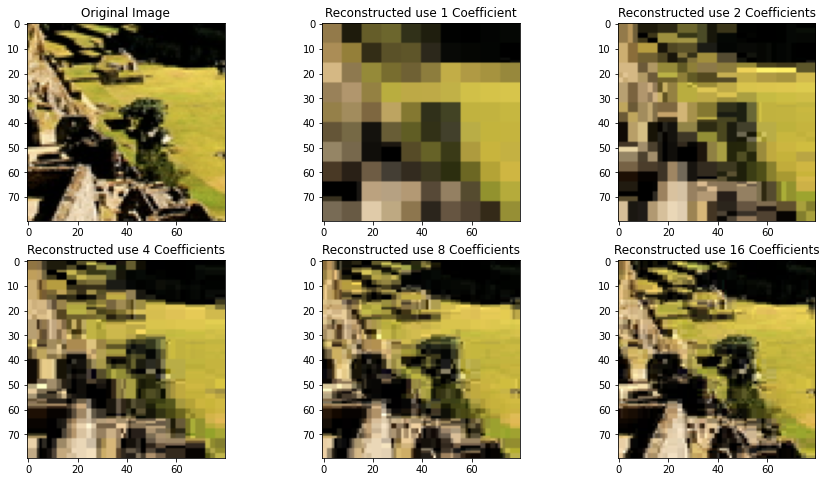

In [24]:
f, ax = plt.subplots(2, 3, figsize=(15,8))
ax[0][0].imshow(I[240:320,280:360,:])
ax[0][0].set_title("Original Image")
ax[0][1].imshow(Grid_fig(ReconCoef1)[240:320,280:360,:])
ax[0][1].set_title("Reconstructed use 1 Coefficient")
ax[0][2].imshow(Grid_fig(ReconCoef2)[240:320,280:360,:])
ax[0][2].set_title("Reconstructed use 2 Coefficients")
ax[1][0].imshow(Grid_fig(ReconCoef4)[240:320,280:360,:])
ax[1][0].set_title("Reconstructed use 4 Coefficients")
ax[1][1].imshow(Grid_fig(ReconCoef8)[240:320,280:360,:])
ax[1][1].set_title("Reconstructed use 8 Coefficients")
ax[1][2].imshow(Grid_fig(ReconCoef16)[240:320,280:360,:])
ax[1][2].set_title("Reconstructed use 16 Coefficients")

When zooming in it is obvious that with fewer coefficients being used(higher compression ratio) the details of the image becomes less sharp. And when we are using fewer basises for reconstruction, the individual pixels in each $8 \times 8$ blocks become hard to distinguish, instead those blocks are filled with smaller color patterns, and with less coefficients this phenomenom becomes more obvious.